<a href="https://colab.research.google.com/github/AishwaryaNambissan/Code/blob/main/MiniBatchKMeans_LargeDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim import models

%pip install ijson
import ijson

import pandas as pd

from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import strip_short
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_tags
from gensim.parsing.preprocessing import strip_numeric
from gensim.parsing.preprocessing import strip_non_alphanum
from gensim.parsing.preprocessing import strip_short
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import STOPWORDS
from nltk.tokenize import word_tokenize

import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

from collections import Counter
import csv
from wordcloud import WordCloud

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.8/111.8 kB 2.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
file =  '/content/gdrive/MyDrive/Colab Notebooks/extracted_files/json/artificial_intelligence.json'
affs = set()
author_names = set()
content = []
doi=[]
counter = 0
try:
    with open(file, 'r') as f:
        # Parse the JSON objects one by one
        parser = ijson.items(f, 'item')

        # Iterate over the JSON objects
        for item in parser:
          counter = counter + 1
          try:
            # Process each JSON object as needed
            if 'abstract' in item.keys() and 'title' in item.keys():
              title = ' '.join(item['title'])
              content.append(item['abstract']+ " " + title)
              doi.append(item.get('DOI', ''))

            if 'author' in item.keys():
              authors = item['author']
              for val in authors:
                # Both given and family names have to exist to be counted
                if 'given' in val.keys() and 'family' in val.keys():
                # Extract the name of the author from the given and family names
                  name = val['given'] + " " + val['family']
                # Add the author's name to the set of authors
                  author_names.add(name)

                if 'affiliation' in val.keys():
                  # Extract the name of the author
                  affiliations = val['affiliation']
                  if len(affiliations) > 0:
                    for aff in affiliations:
                      if 'name' in aff.keys():
                        name = aff['name']
                        # Add the author's affiliation to the set of affiliations
                        affs.add(name)

          except Exception as e:
              print("Error processing JSON item:", str(e))
except FileNotFoundError:
  print("File not found:", file)
except Exception as e:
  print("Error reading file:", str(e))

print("Number of records", counter)
print("Number of affiliations:", len(affs))
print("Number of co-authors:", len(author_names))


Number of records 501629
Number of affiliations: 163722
Number of co-authors: 736857


Creating the dataframe with required feature

In [4]:
df = pd.DataFrame(columns=['content', 'doi'])
# Convert JSON to DataFrame Using read_json()
df['content'] = pd.DataFrame(content)
df['doi'] = pd.DataFrame(doi)


# Checking for missing values
df.isnull().sum()

# Dropping those columns with null values for abstract and title
df = df.dropna()
df.shape
df.head()

content    0
doi        0
dtype: int64


,content,doi
0,<jats:p> Artificial immune system is inspired ...,10.1142/s0218213012500315
1,<jats:p> Accurate time series forecasting are ...,10.1142/s0218213011000462
2,<jats:p> This paper addresses the problem of e...,10.1142/s0218213019400086
3,<jats:p> Recent trends in educational technolo...,10.1142/s0218213019400062
4,<jats:p> As the dairy products have a short co...,10.1142/s0218213020500086


Preprocessing and Cleaning the data

In [5]:
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, strip_non_alphanum,  lambda x: strip_short(x, minsize=4)]

filtered_text = []
for item in df['content'].astype(str):
  filtered_text.append(preprocess_string(item, CUSTOM_FILTERS))


Lemmatization

In [6]:
import nltk

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [7]:
lemmatized_words = [[lemmatizer.lemmatize(word) for word in sublst] for sublst in filtered_text]


In [8]:
print("One row of Lemmatized words")
print(lemmatized_words[0])

One row of Lemmatized words
['artificial', 'immune', 'system', 'inspired', 'natural', 'immune', 'system', 'solving', 'computational', 'problem', 'immunological', 'principle', 'that', 'primarily', 'used', 'artificial', 'immune', 'system', 'clonal', 'selection', 'principle', 'immune', 'network', 'theory', 'negative', 'selection', 'mechanism', 'these', 'principle', 'have', 'been', 'applied', 'anomaly', 'detection', 'pattern', 'recognition', 'computer', 'network', 'security', 'dynamic', 'environment', 'learning', 'robotics', 'data', 'analysis', 'optimization', 'scheduling', 'timetabling', 'this', 'paper', 'describes', 'these', 'three', 'immunological', 'principle', 'were', 'adapted', 'previous', 'researcher', 'their', 'artificial', 'immune', 'system', 'model', 'algorithm', 'finally', 'application', 'various', 'artificial', 'immune', 'system', 'various', 'domain', 'summarized', 'time', 'line', 'immunology', 'artificial', 'immune', 'system']


Removing stop words

In [9]:
nltk.download('punkt')

stop_words = STOPWORDS.union(set(['jats', 'ai', 'artificial', 'intelligence', 'research','technology','article', 'pattern','compared',
                                  'development', 'paper', 'application', 'method','deep','algorithm', 'problem', 'model', 'iso', 'function',
                                  'noise', 'sample', 'layer', 'optimization', 'solution','term','including', 'factor','tool','main','experimental',
                                  'optimal', 'parameter', 'predict', 'forecast', 'cluster','classifier', 'label', 'class','input','world',
                                  'test', 'training', 'case', 'level', 'give', 'focus','change','current','point','important','number','strategy',
                                  'real', 'however', 'review', 'need', 'various', 'many', 'solve', 'analyze', 'human','significant','source',
                                  'include', 'datasets','dataset','image', 'approach', 'accuracy', 'information','component','potential',
                                  'also', 'time', 'show',  'provide', 'task', 'make','existing','multiple','making','activity','search',
                                  'performance', 'knowledge', 'user', 'feature', 'proposed','propose','year','related','efficient','rate',
                                  'process', 'system', 'well', 'study','form','effective','example','better','characteristic','support',
                                  'different', 'high', 'improve', 'design', 'recognition','specific','finally','novel','order','purpose',
                                  'train', 'compare', 'field', 'apply', 'develop', 'based','content','impact','possible','error','presented',
                                  'technique', 'analysis', 'present', 'work','condition','implementation','evaluation','increase','target',
                                  'learn', 'machine', 'language', 'large','issue','value','given','higher','context','scale','complex',
                                  'intelligent', 'base', 'neural', 'network', 'framework','learning','developed','best','multi','fuzzy',
                                  'result', 'use', 'supervised', 'representation', 'domain', 'architecture','provides','obtained','like',
                                  'prediction', 'classification', 'natural', 'conference', 'data','identify','concept','available','world',
                                  'conclusion', 'objective', 'abstract','background', 'author', 'disclosure', 'title', 'computer', 'agent',
                                  'challenge','processing', 'future', 'recent', 'transfer', 'state', 'yang','evolutionary','program','combination',
                                  'vector','chapter','theory','aim','addition', 'step','cost','type','part','efficiency','complexity',
                                  'comparison','set','experiment','measure','quality','operation','difference','direction','practice',
                                  'platform','range','researcher','area','stage','object','structure','decision','mean','finding','response',
                                  'effect','group','effectiveness','size','people','way','science','question','role','requirement','goal',
                                  'implement','nan', 'mechanism', 'modeling','second','considered','space','simulation','internet',
                                  'standard','variable','physical','interaction','local','methodology','spatial','smart','significantly',
                                  'a', 'an', 'the', 'in', 'on', 'at', 'from', 'to', 'with', 'over', 'under','and', 'but', 'or', 'so', 'nor', 'for',
                                  'yet', 'i', 'you', 'he', 'she','it', 'we', 'they', 'me', 'him', 'her', 'us', 'them','is', 'am', 'are', 'was',
                                  'were', 'be', 'been', 'being','have', 'has', 'had', 'do', 'does', 'did', 'will', 'shall','can', 'could', 'would',
                                  'should', 'may', 'might', 'must', 'ought', 'that','this', 'these', 'those', 'how', 'what', 'why', 'by', 'their',
                                  'of', 'as', 'there','within', 'which']))


s = ""
print(stop_words)
cleaned_text_list = []
for line in lemmatized_words:
  s = " ".join(line)
  tokenized_text = word_tokenize(s)
  cleaned_text = [word for word in tokenized_text if word.lower() not in stop_words]
  cleaned_text_list.append(cleaned_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


frozenset({'learn', 'current', 'base', 'increase', 'but', 'well', 'supervised', 'such', 'thus', 'issue', 'type', 'off', 'paper', 'an', 'latter', 'seem', 'forty', 'her', 'therein', 'user', 'de', 'in', 'potential', 'spatial', 'again', 'becoming', 'else', 'significant', 'classifier', 'algorithm', 'us', 'nothing', 'serious', 'give', 'five', 'until', 'these', 'herein', 'became', 'beforehand', 'shall', 'very', 'proposed', 'six', 'fire', 'forecast', 'year', 'analyze', 'behind', 'solution', 'data', 'yang', 'never', 'predict', 'eight', 'performance', 'standard', 'train', 'its', 'via', 'size', 'source', 'article', 'stage', 'form', 'who', 'other', 'artificial', 'amount', 'simulation', 'main', 'fill', 'none', 'third', 'into', 'develop', 'obtained', 'complex', 'to', 'throughout', 'ever', 'efficient', 'nobody', 'noone', 'direction', 'conference', 'propose', 'nan', 'found', 'without', 'decision', 'tool', 'learning', 'system', 'across', 'still', 'everything', 'were', 'kg', 'concept', 'layer', 'back', 

Converting categorical string data into vectors

In [10]:
# Convert cleaned text list to a single string
documents = [' '.join(line) for line in cleaned_text_list]

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Vectorize the documents
X = vectorizer.fit_transform(documents)


Finding the optimal number of clusters using elbow plot

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


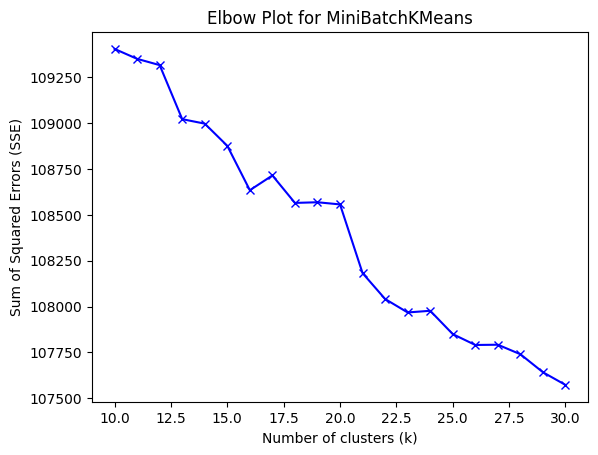

In [11]:
# Initialize list to store sum of squared distances
sse = []
kmeans_list= []
# Set range of values for number of clusters
k_values = range(10, 31)

# Fit MiniBatchKMeans model for each value of k
for k in k_values:
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=100)
    kmeans_list.append(kmeans.fit(X))
    sse.append(kmeans.inertia_)

# Plot elbow plot
plt.plot(k_values, sse, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Plot for MiniBatchKMeans')
plt.show()

Fetching required fields from clustering


In [16]:

# Initialize the mini-batch K-means algorithm
k = 24  # Number of optimal clusters
mbk = kmeans_list[k-10]

# Get the top 10 keywords of each cluster and the number of documents in each of them
preds = mbk.fit_predict(X)
labels = mbk.labels_
terms = vectorizer.get_feature_names_out()
predicted_labels = mbk.predict(X)

score = silhouette_score(X, preds)

print("Silhouette score:", score)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score: 0.0060494685694229226


Top 10 keywords of each cluster


Cluster 0:
vehicle
autonomous
traffic
control
road
driving
environment
detection
unmanned
safety


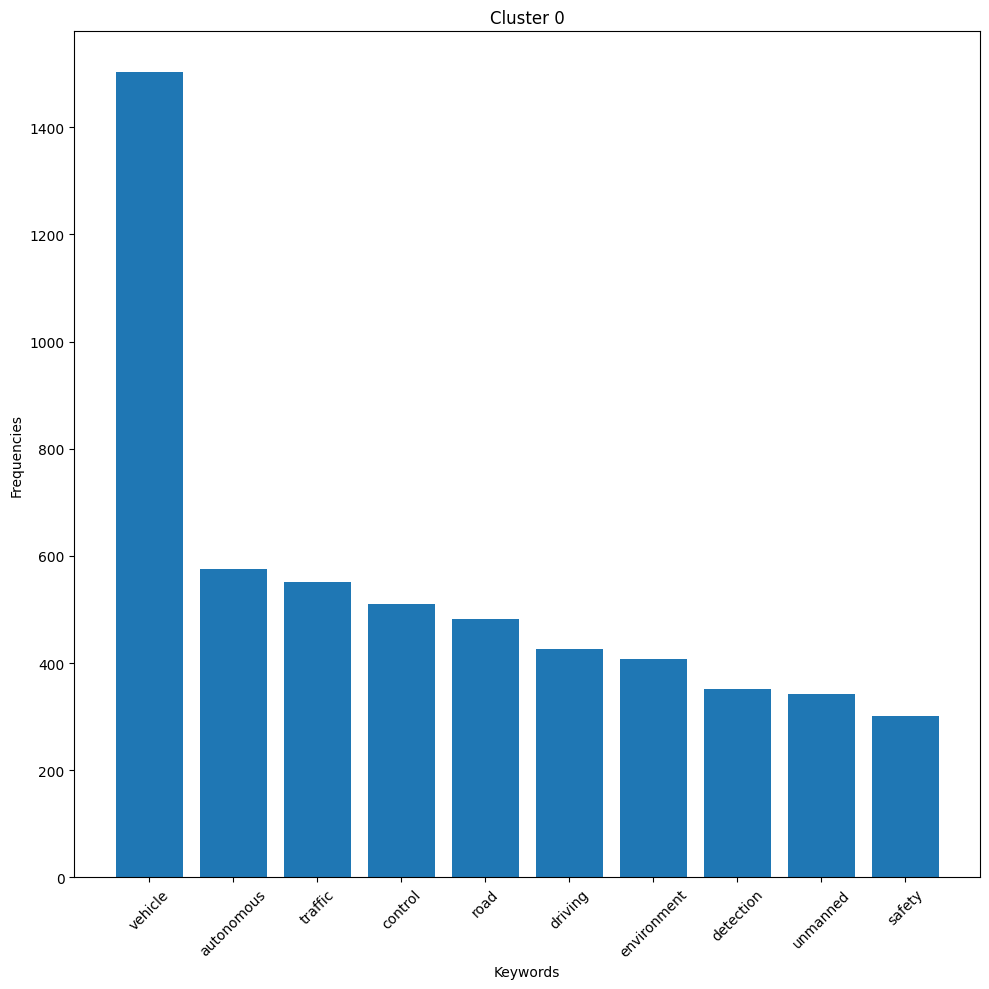

Cluster 1:
visual
stimulus
perception
motion
subject
perceived
observer
vision
perceptual
contrast


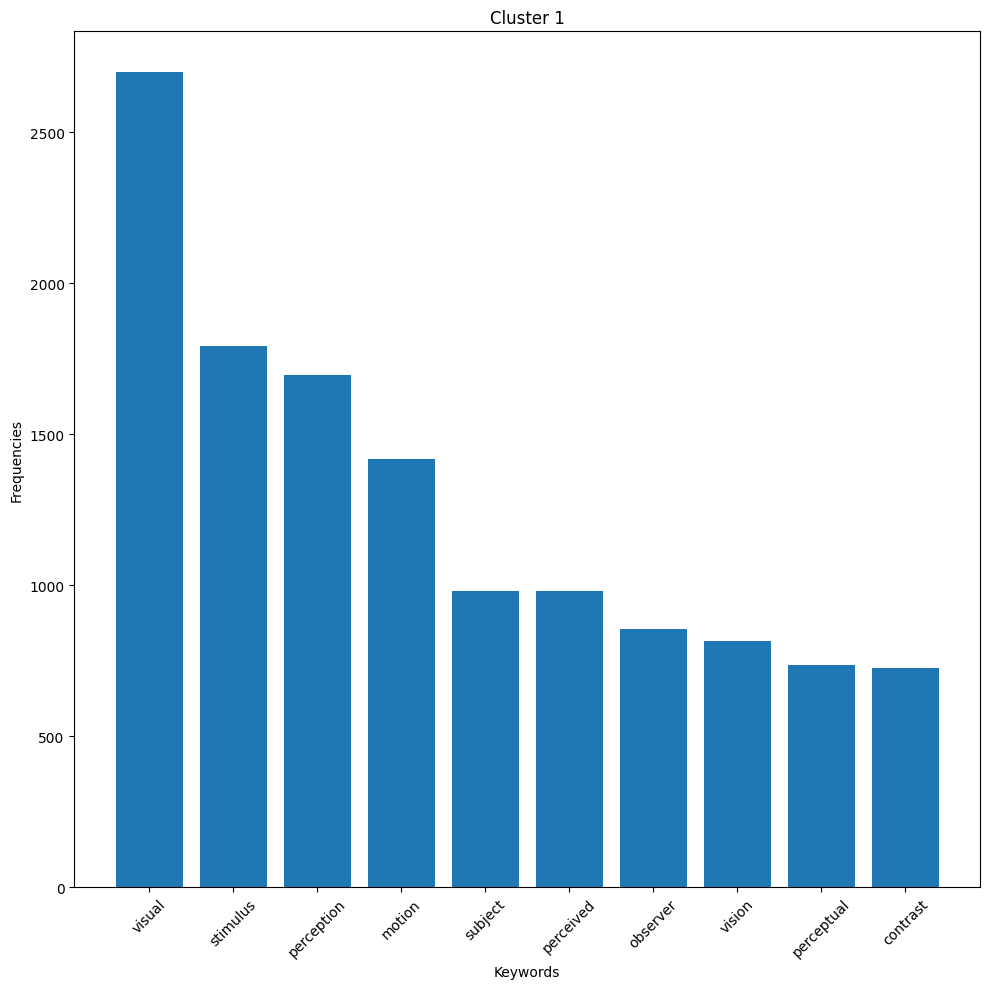

Cluster 2:
student
education
teaching
educational
teacher
university
course
school
environment
online


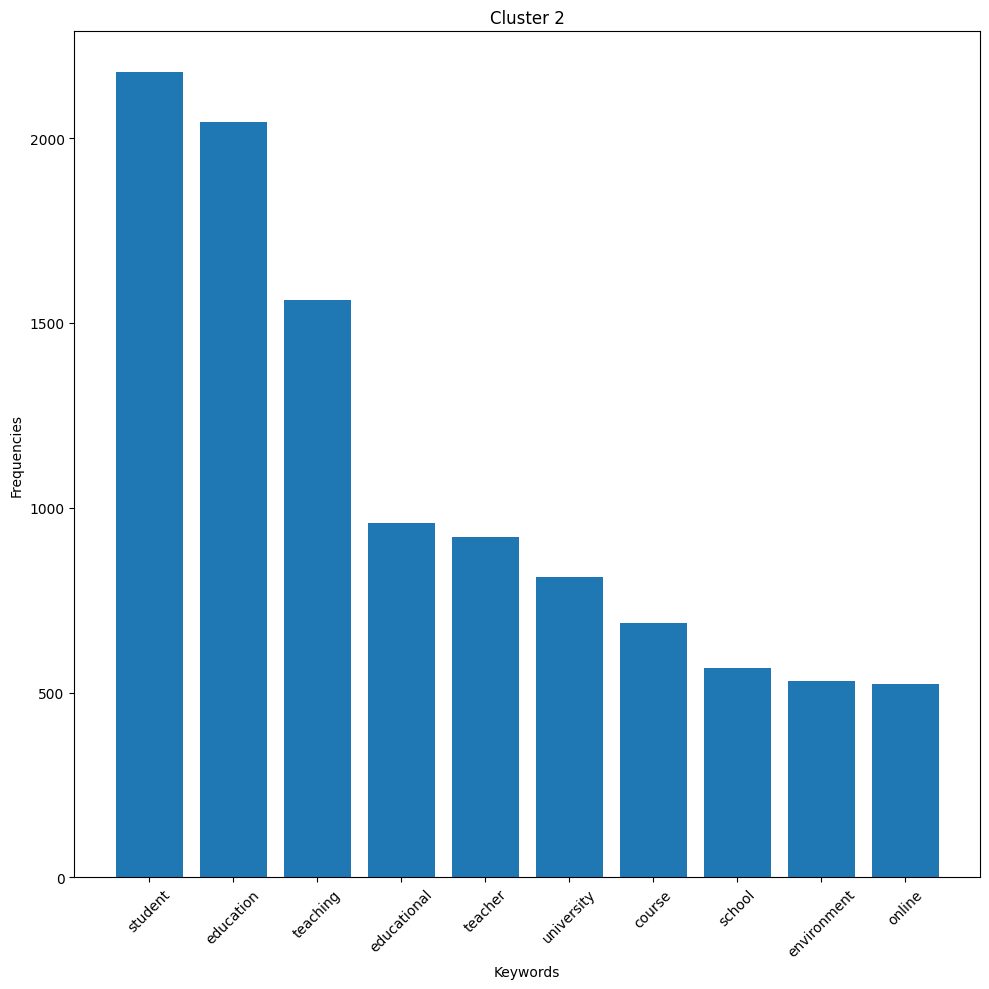

Cluster 3:
applied
environment
property
detection
control
dynamic
computational
demonstrate
help
known


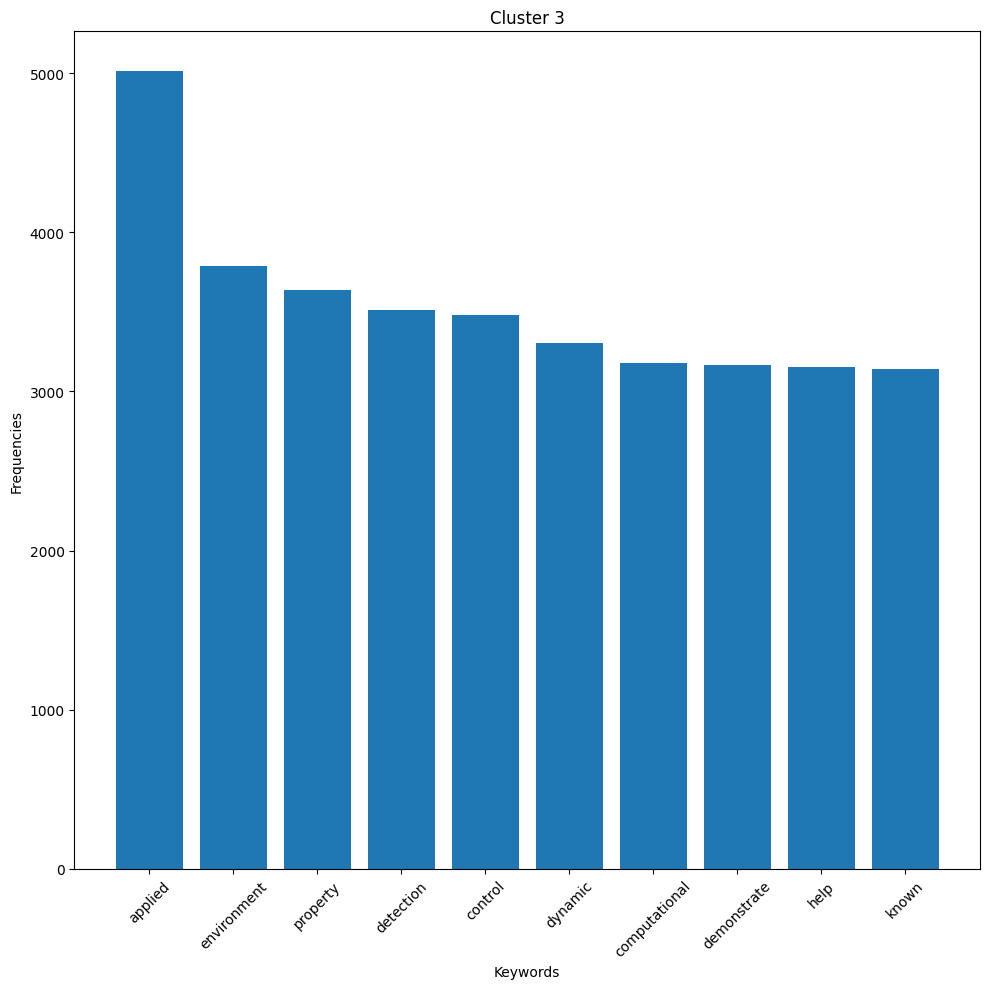

Cluster 4:
cancer
patient
diagnosis
clinical
treatment
tumor
detection
breast
imaging
early


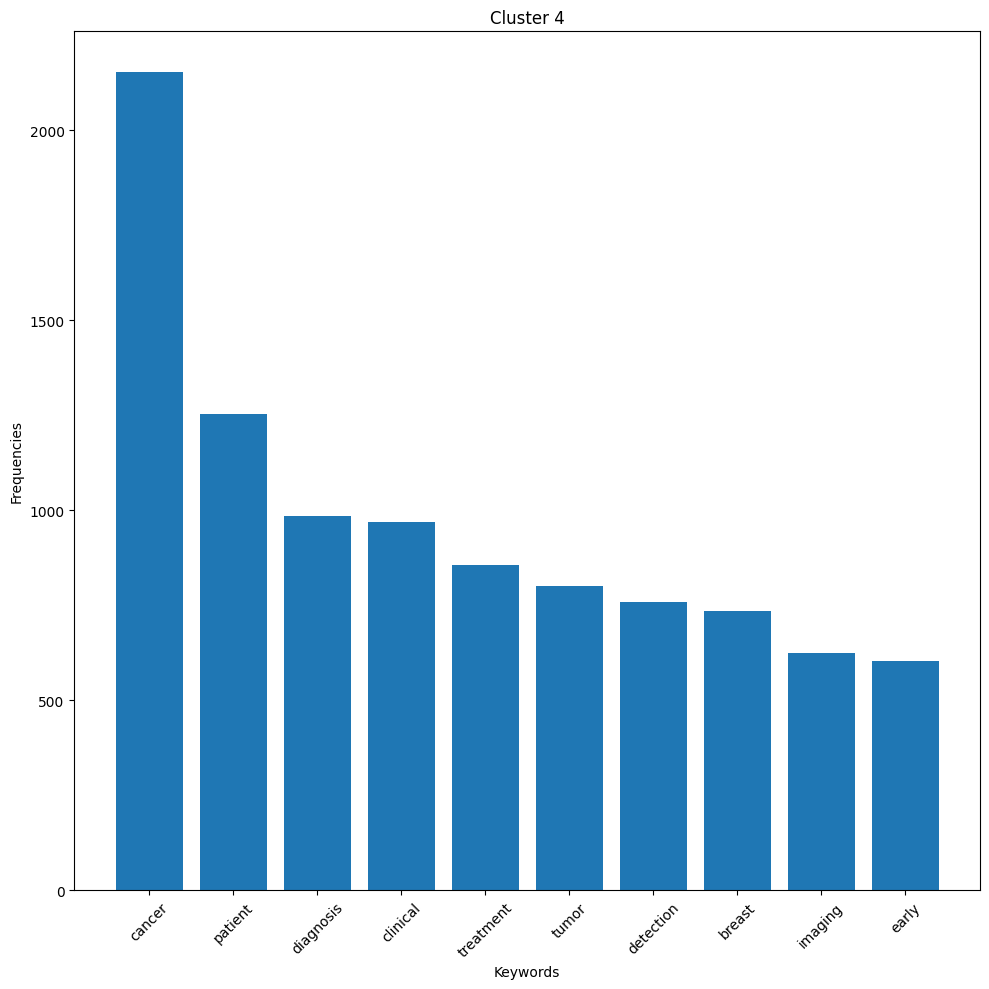

Cluster 5:
energy
power
consumption
control
grid
renewable
generation
demand
management
load


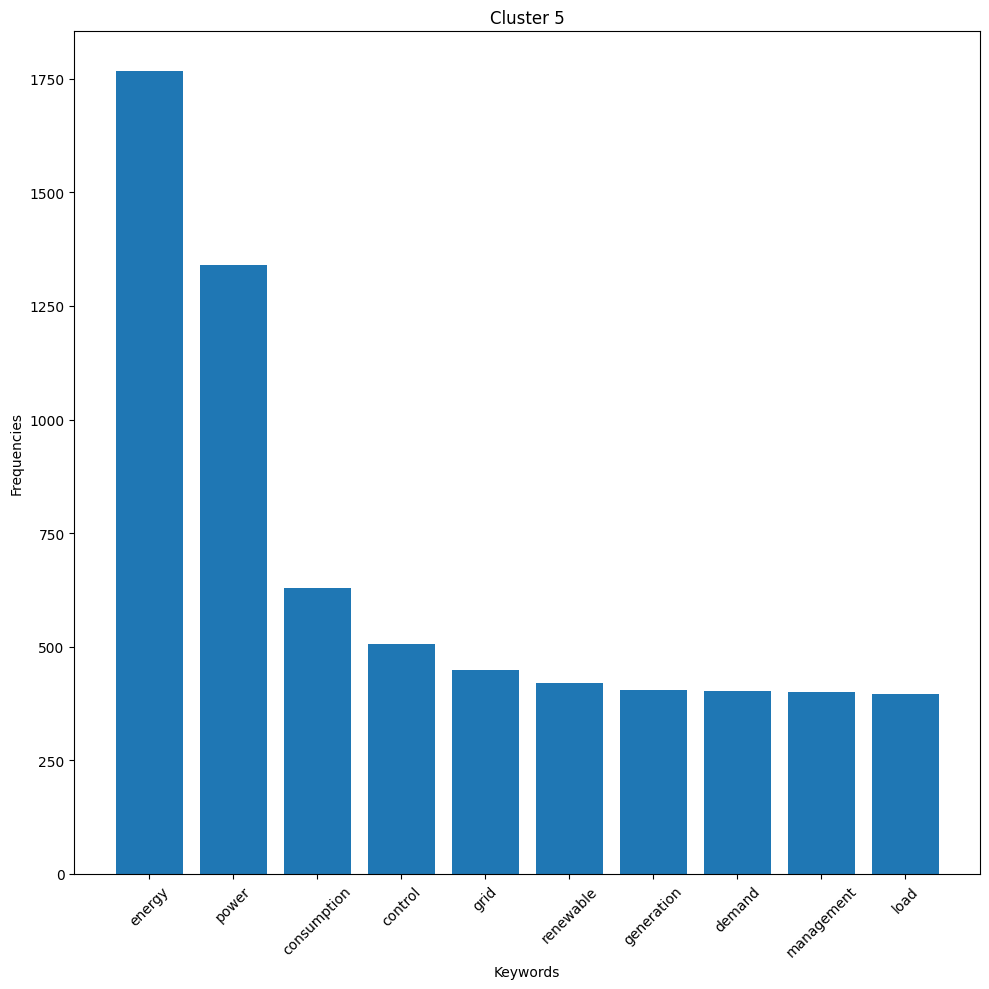

Cluster 6:
social
life
society
medium
legal
understanding
ethical
perspective
technological
public


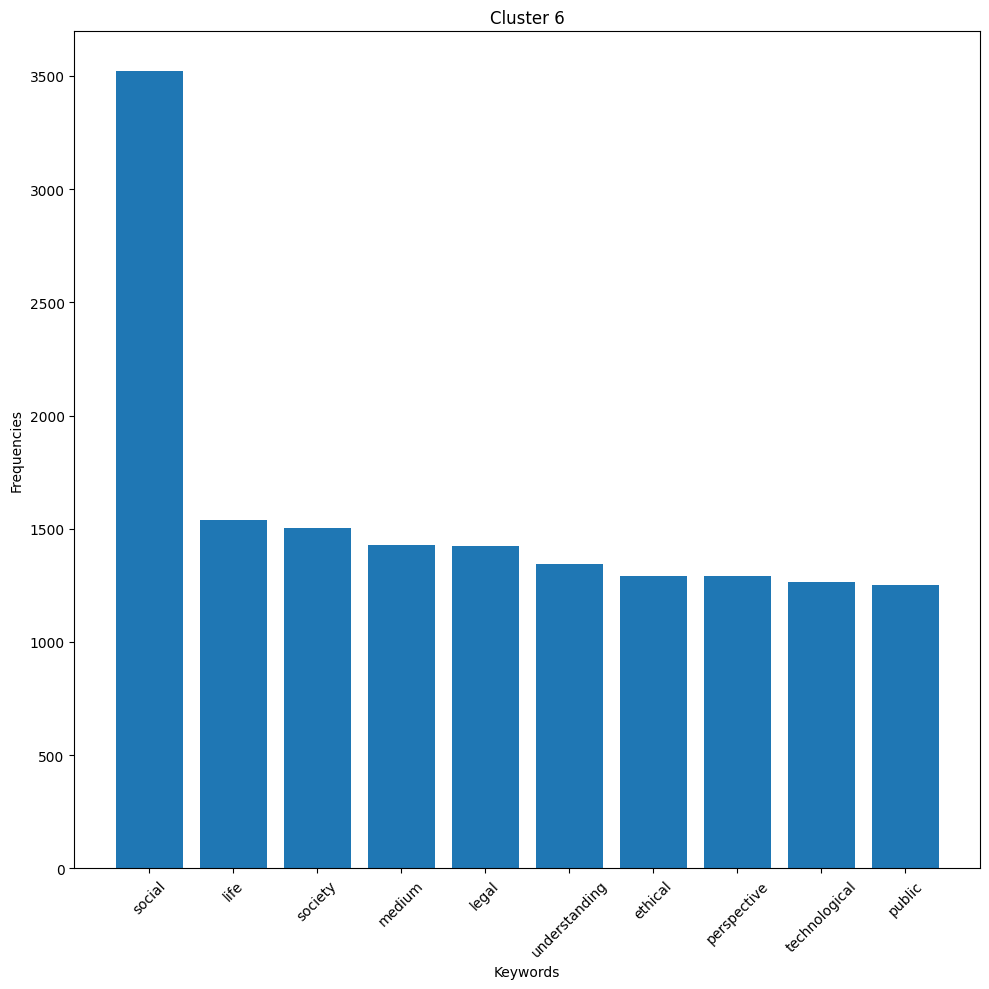

Cluster 7:
logic
reasoning
programming
rule
semantics
constraint
property
answer
general
particular


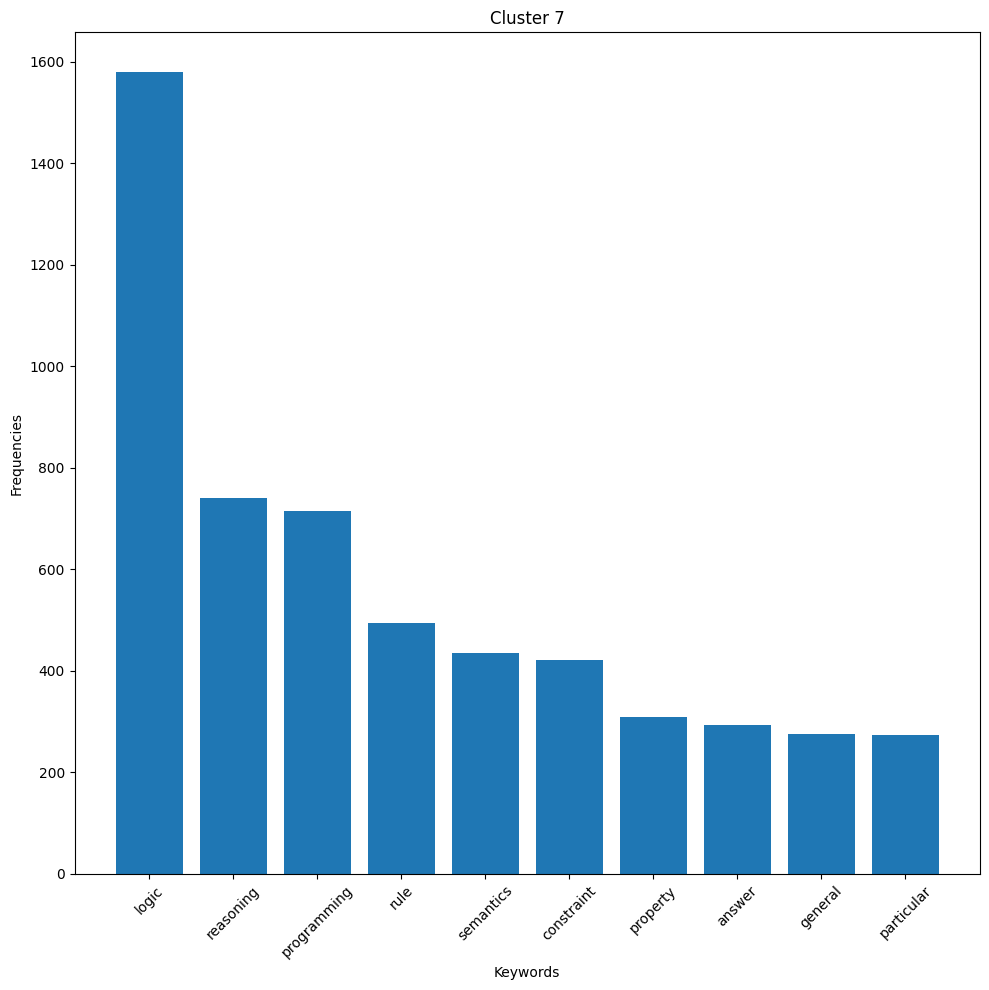

Cluster 8:
security
computing
cloud
attack
device
thing
service
environment
resource
cyber


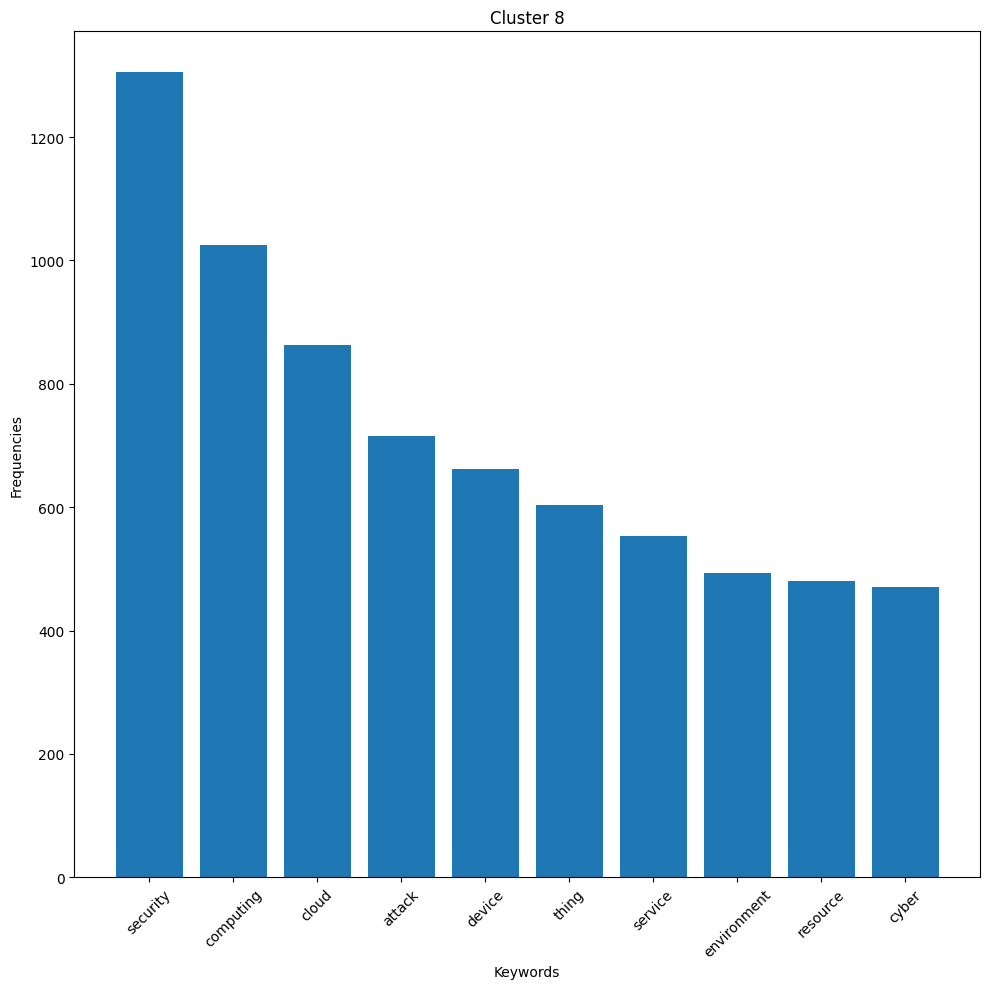

Cluster 9:
digital
management
industry
business
company
industrial
economic
transformation
economy
production


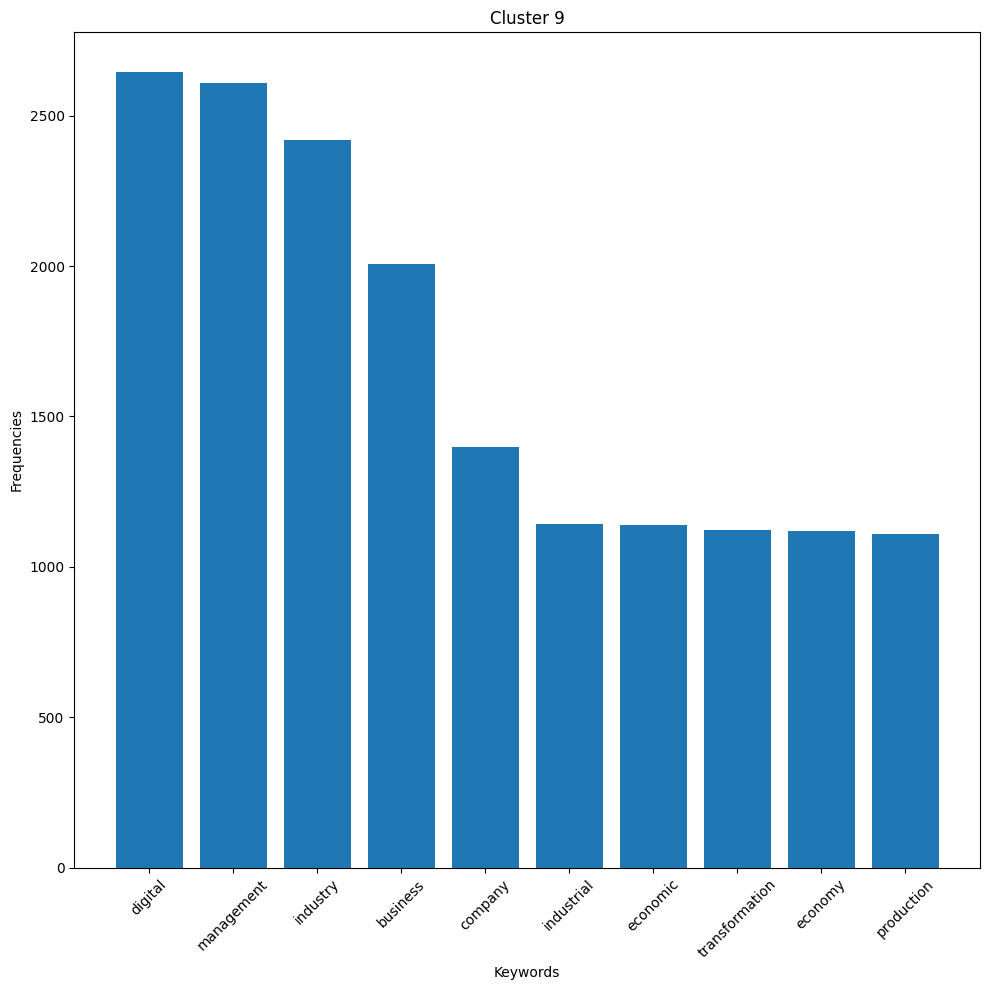

Cluster 10:
patient
clinical
disease
health
medical
diagnosis
care
treatment
healthcare
risk


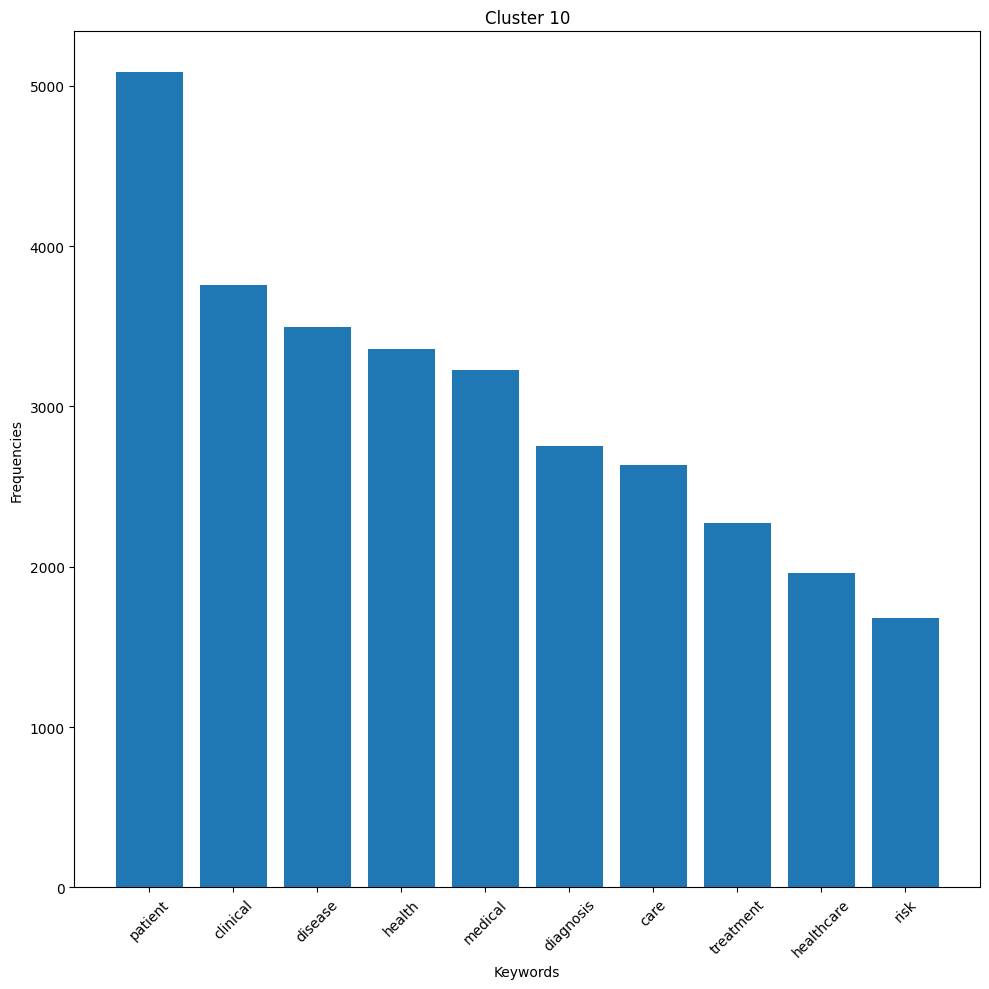

Cluster 11:
service
customer
city
management
environment
business
industry
digital
resource
literature


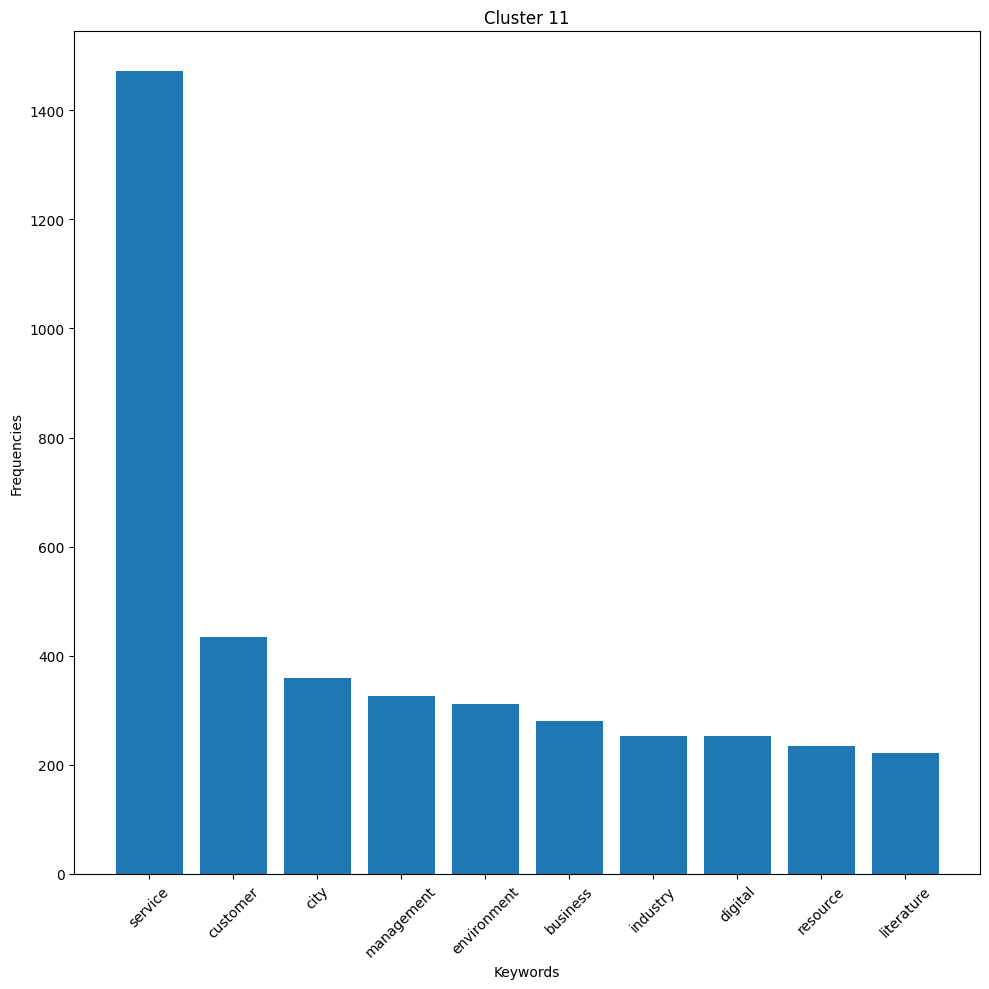

Cluster 12:
sensor
detection
signal
monitoring
measurement
applied
estimation
environment
water
accurate


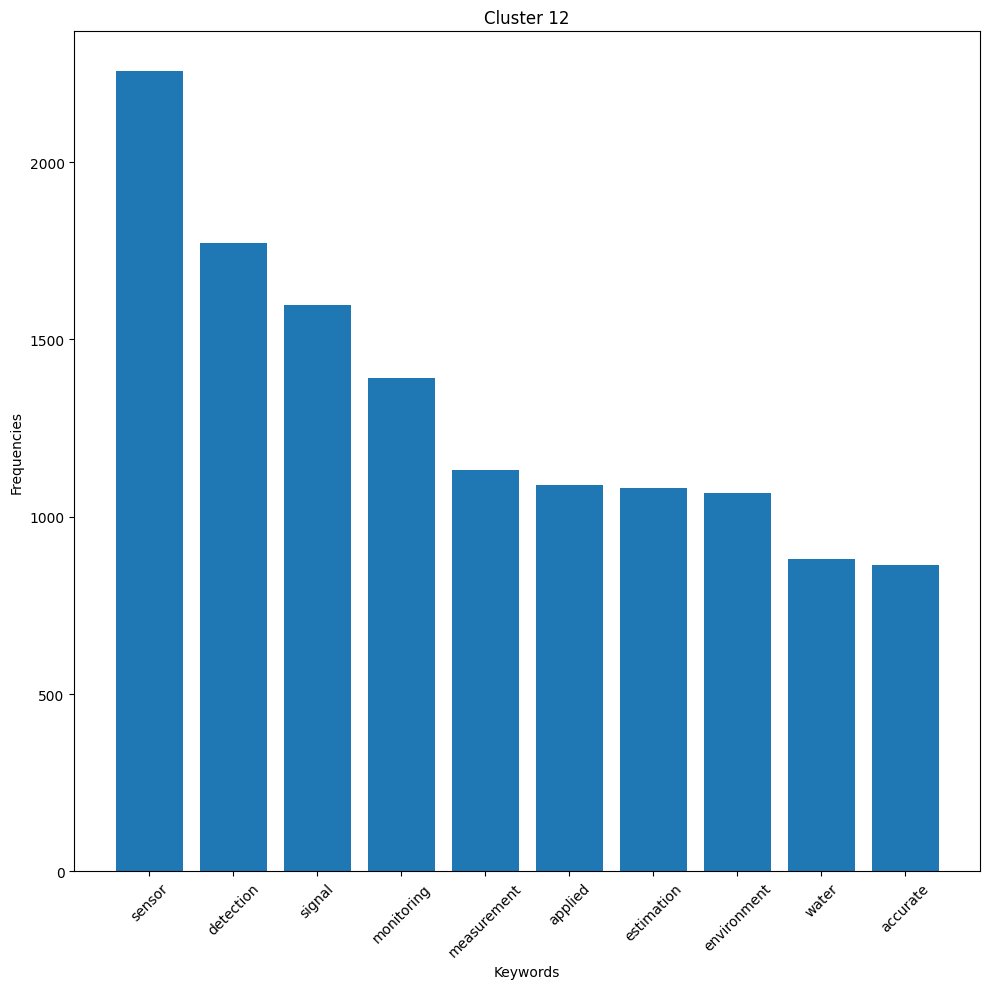

Cluster 13:
game
player
play
environment
playing
experience
behavior
video
action
general


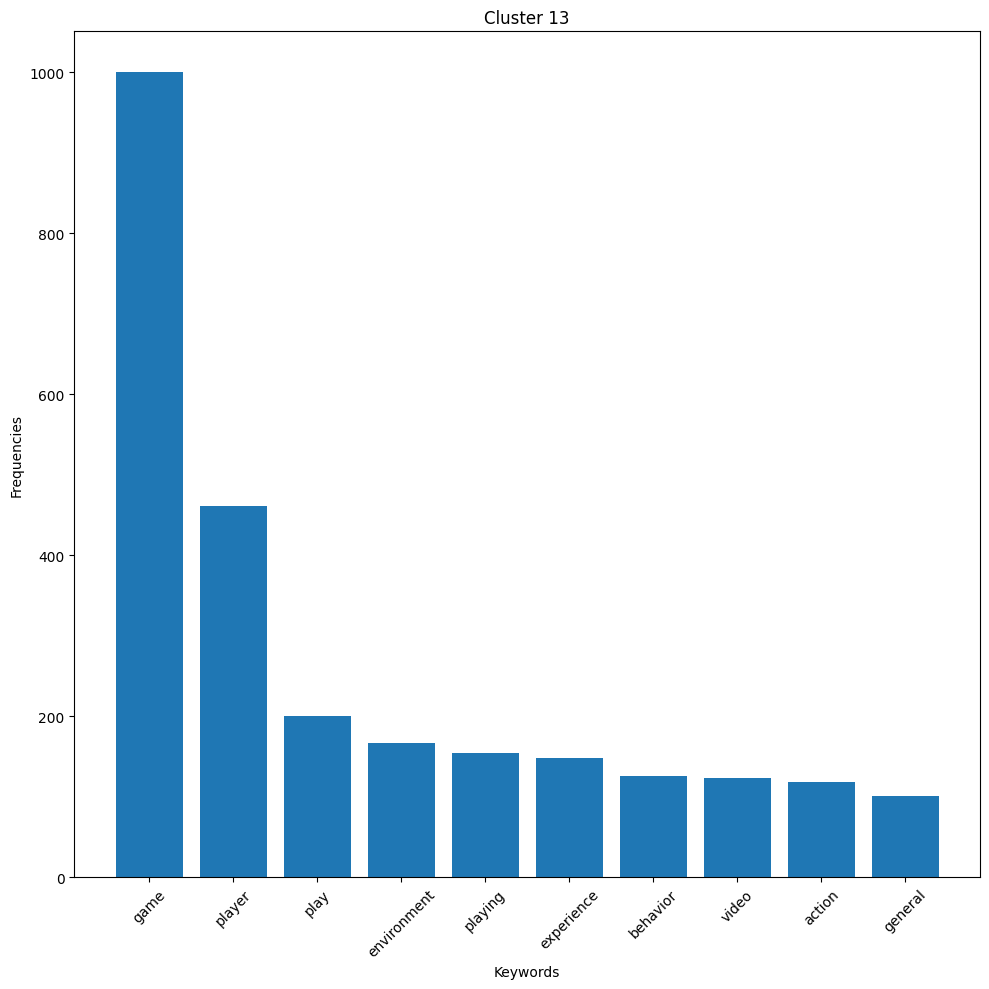

Cluster 14:
clustering
applied
distance
similarity
mining
improved
traditional
density
demonstrate
similar


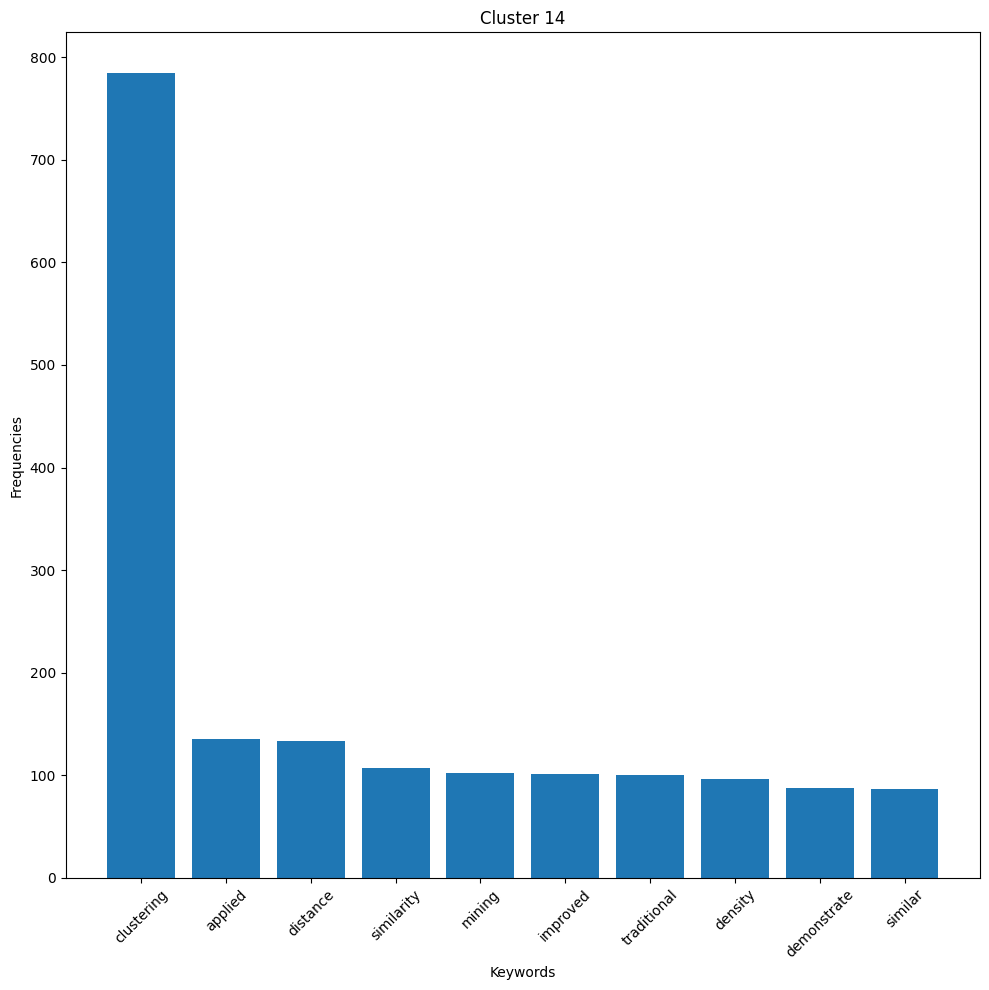

Cluster 15:
graph
node
edge
vertex
property
demonstrate
known
relation
relationship
path


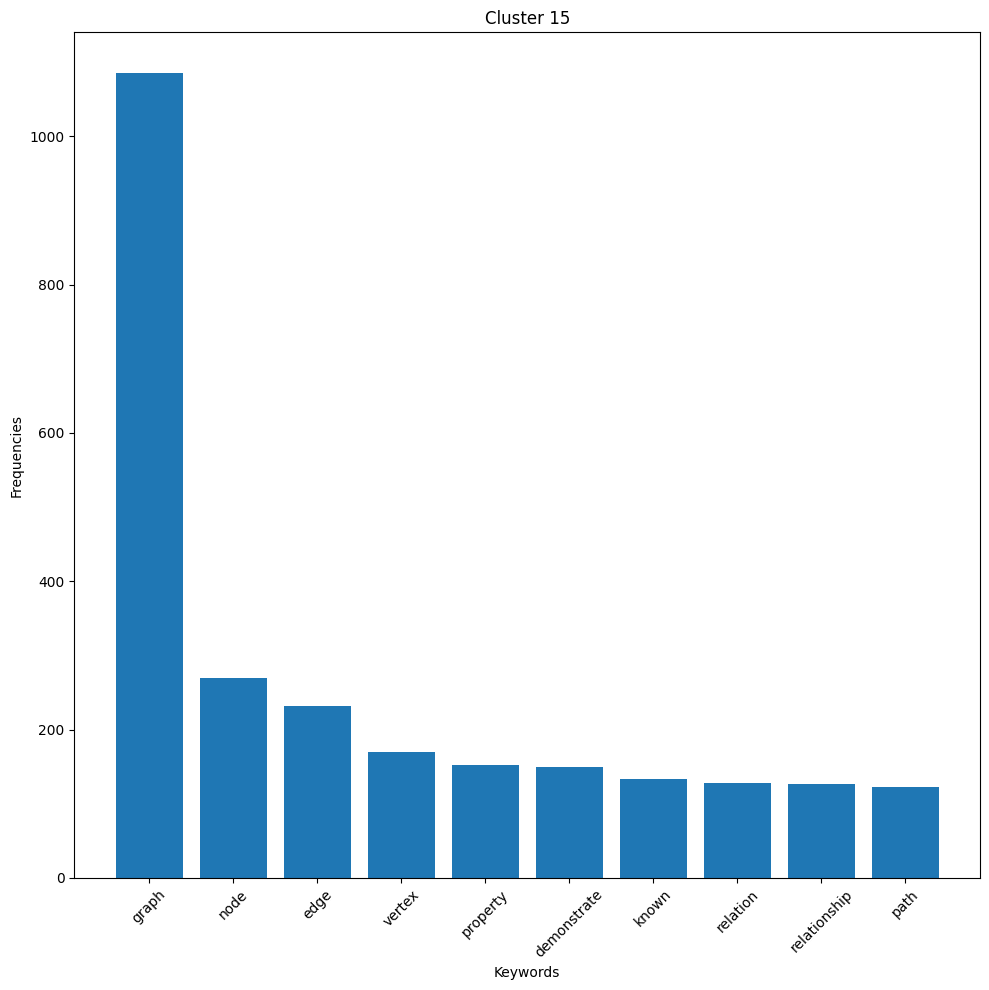

Cluster 16:
covid
pandemic
disease
patient
health
coronavirus
diagnosis
medical
spread
virus


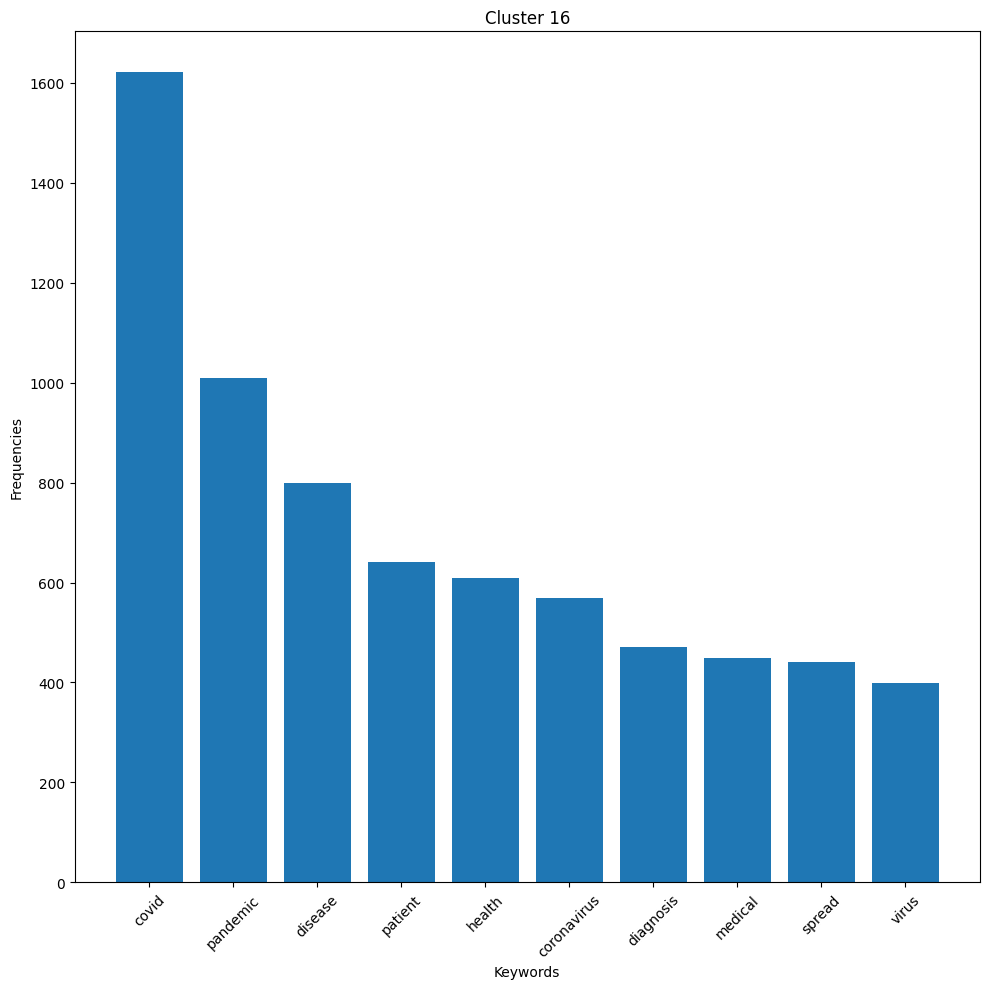

Cluster 17:
control
controller
dynamic
robot
designed
stability
nonlinear
tracking
adaptive
applied


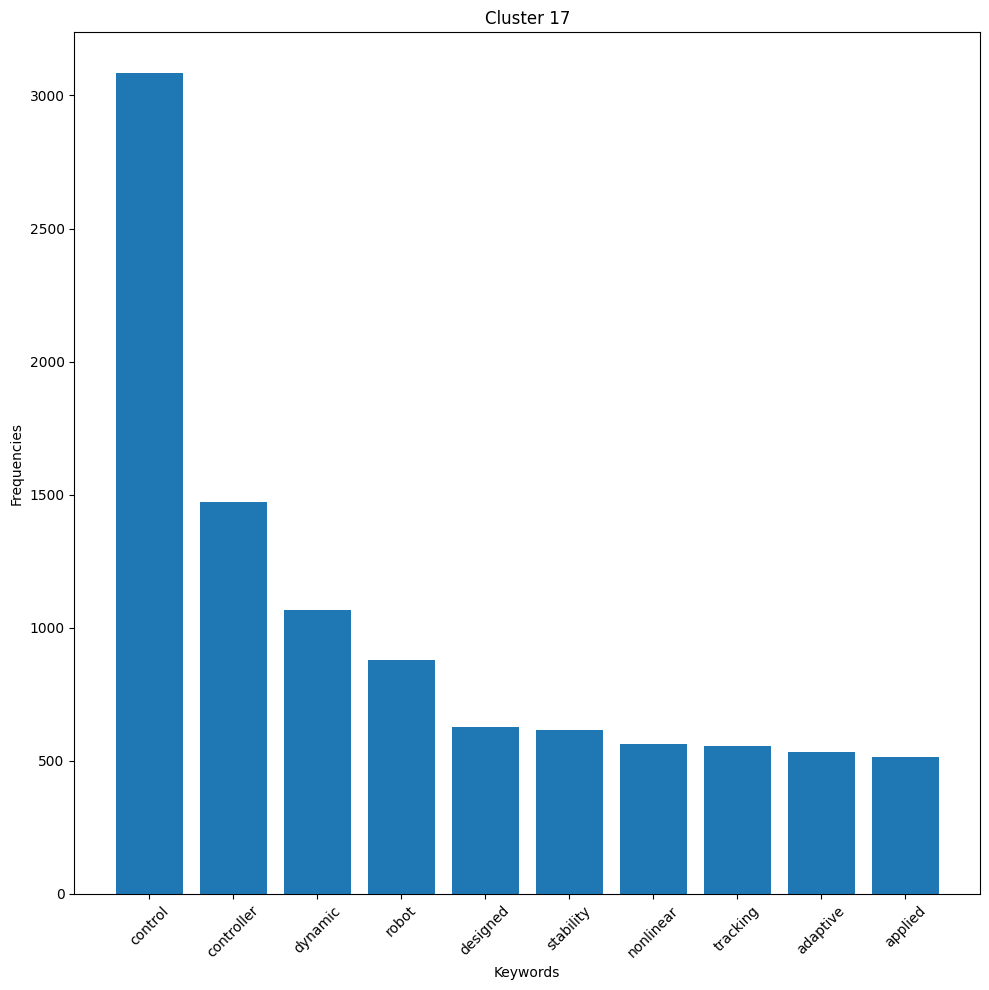

Cluster 18:
robot
environment
control
motion
mobile
robotic
dynamic
robotics
planning
sensor


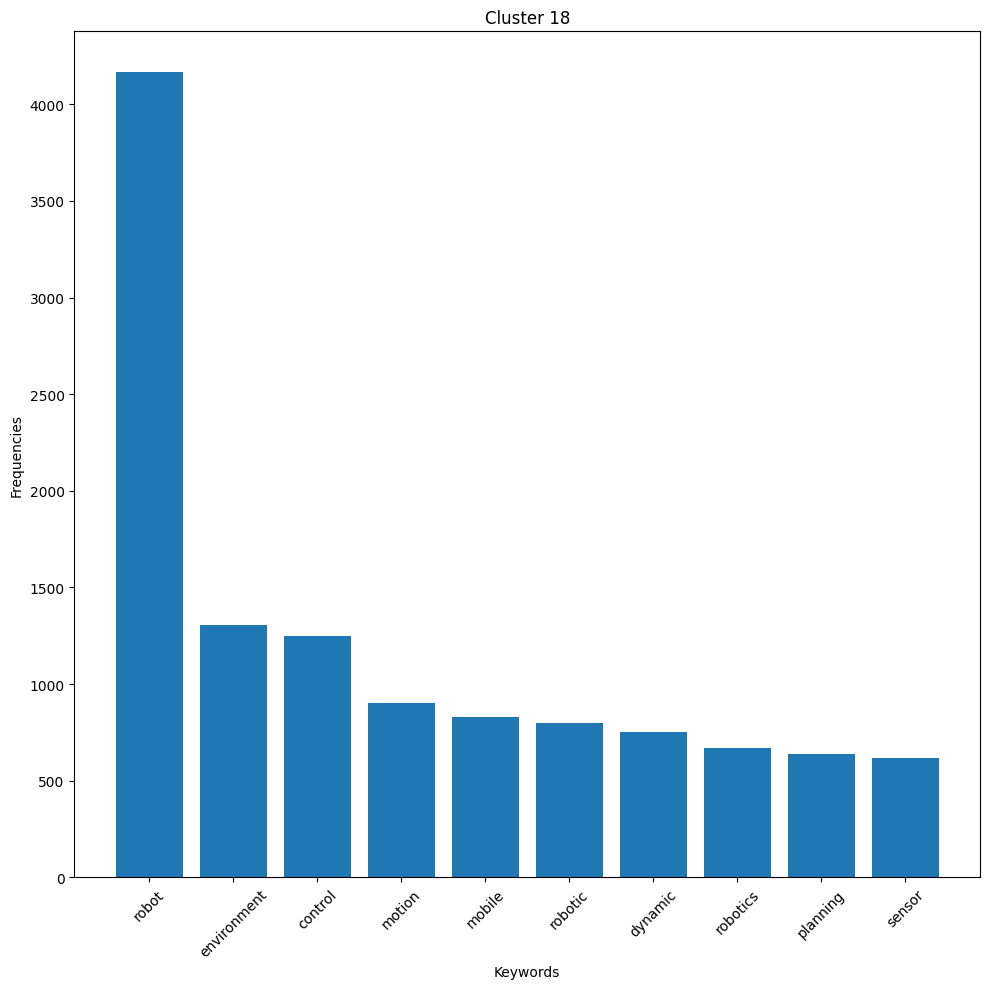

Cluster 19:
tree
forest
random
node
regression
applied
linear
known
shown
rule


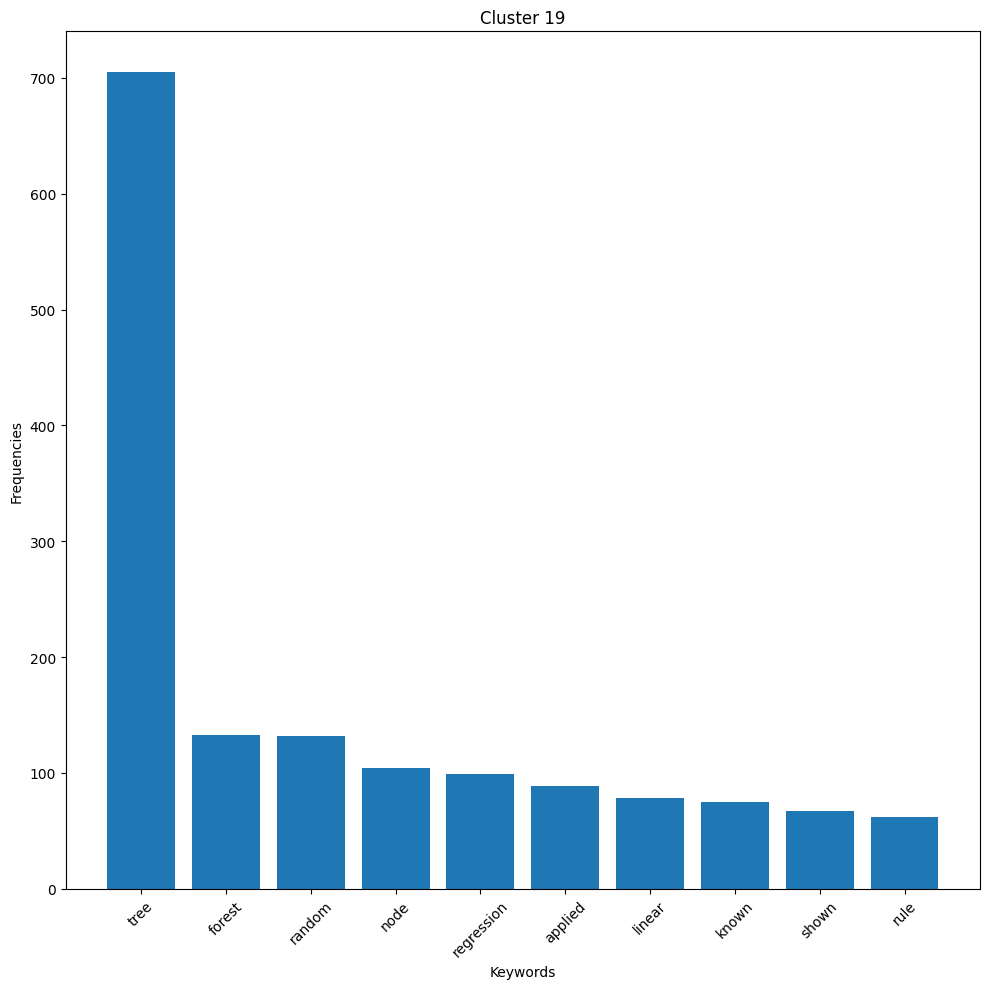

Cluster 20:
text
word
semantic
document
corpus
sentence
english
speech
automatic
extraction


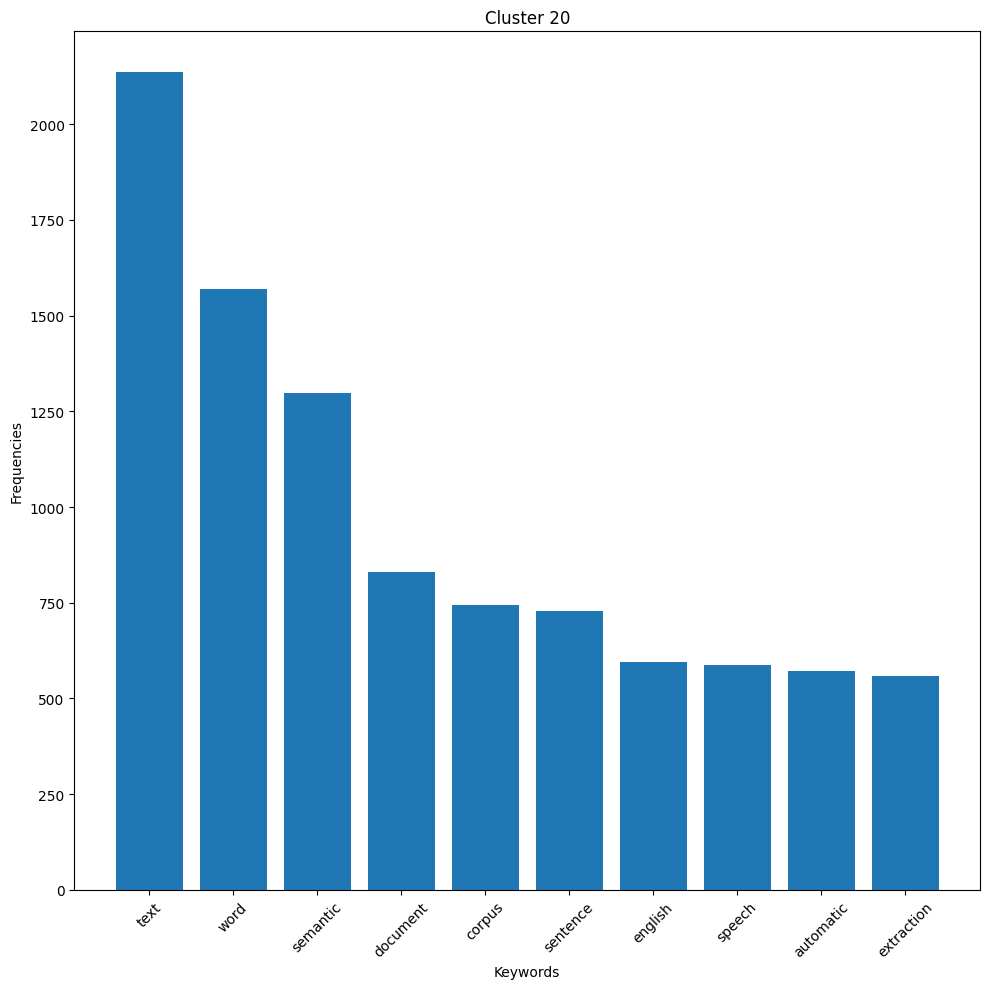

Cluster 21:
video
detection
frame
vision
motion
camera
surveillance
convolutional
sequence
visual


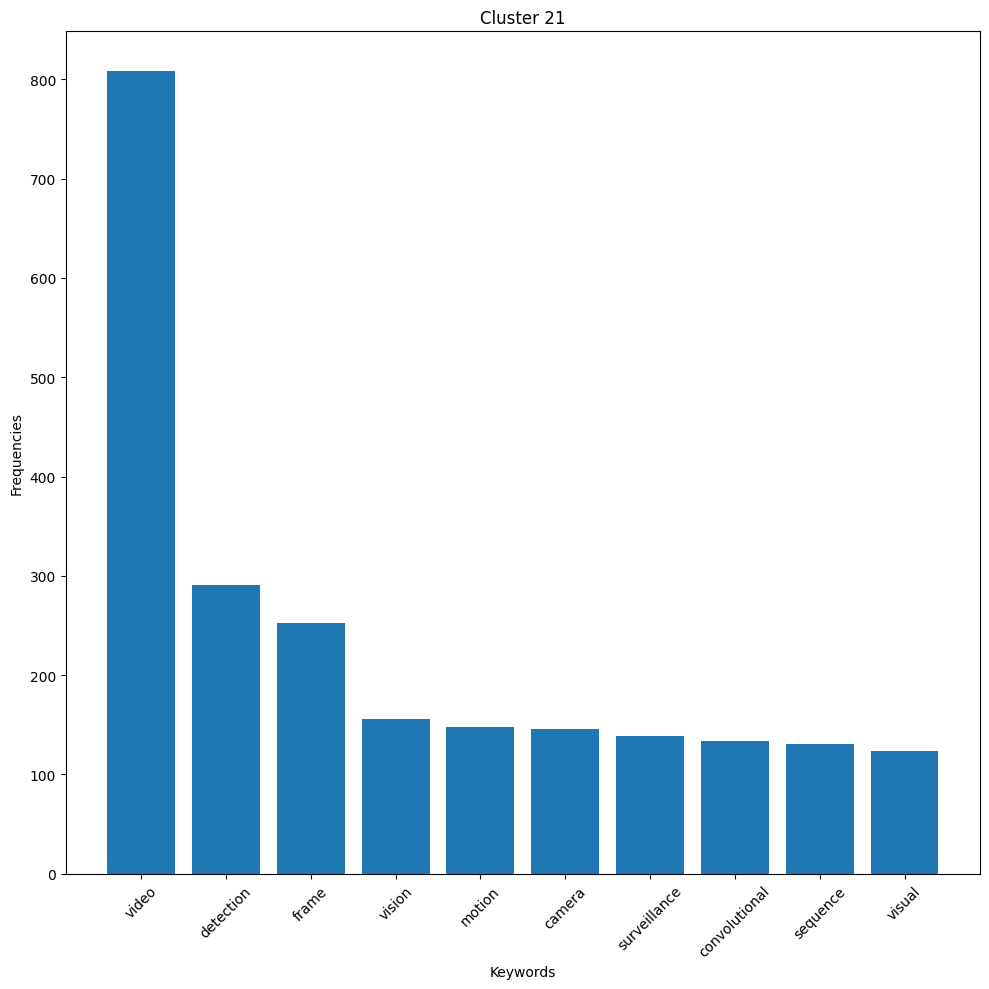

Cluster 22:
face
facial
expression
detection
database
participant
perception
showed
individual
suggest


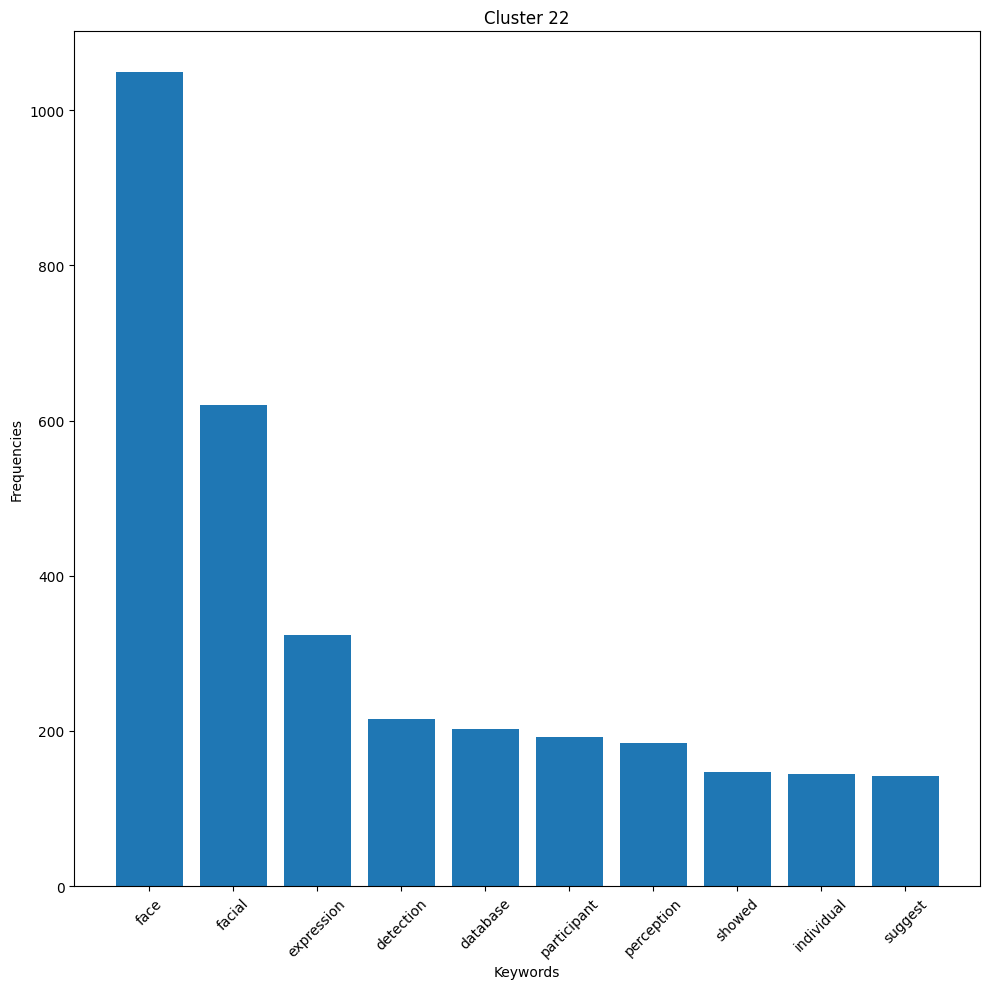

Cluster 23:
fromthis
efficientways
abstractspoken
dave
instruct
aswell
domestic
command
detected
recognise


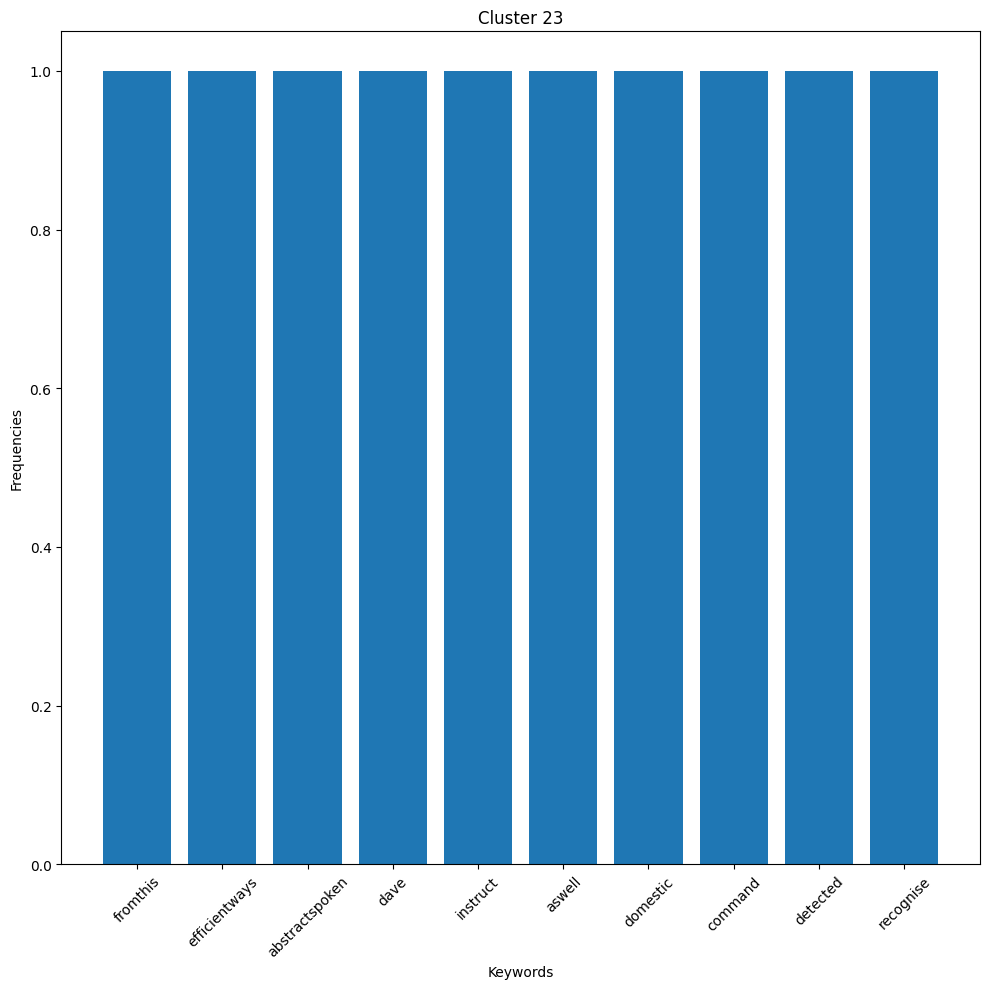

In [14]:
def get_cluster_keywords(vecs, clusters, terms, top_n=10):

    # Dictionary that stores the mapping of clusterids to keywords
    cluster_keyword_ids = {cluster_id: {} for cluster_id in set(clusters)}

    # Dictionary that stores the count of term occurrence
    cluster_keyword_counts = {cluster_id: {} for cluster_id in set(clusters)}

    # loop through the vector and cluster of each doc
    for vec, cluster_id in zip(vecs, clusters):

        # inspect non zero elements of rows of sparse matrix
        for j in vec.nonzero()[1]:

            # check if the keyword already exists in the cluster
            if j not in cluster_keyword_ids[cluster_id]:
                cluster_keyword_ids[cluster_id][j] = 0
                cluster_keyword_counts[cluster_id][j] = 0

            # add a count
            cluster_keyword_ids[cluster_id][j] += 1
            cluster_keyword_counts[cluster_id][j] += 1

    # cluster_keyword_ids contains ids
    # Mapping keywords using labels param
    return {
        cluster_id: [
            (terms[keyword_id], cluster_keyword_counts[cluster_id][keyword_id])  # map from kw id to keyword
            for keyword_id, count in sorted(
                cluster_keyword_id_counts.items(),
                key=lambda x: x[1],  # sort from highest count to lowest
                reverse=True
            )[:top_n]
        ] for cluster_id, cluster_keyword_id_counts in cluster_keyword_ids.items()
    }

# Get the cluster keywords
cluster_keywords = get_cluster_keywords(X, preds, terms, top_n=10)

# Plot the keywords and frequencies for each cluster in the corresponding subplot
for cluster_id, keywords in cluster_keywords.items():
    print(f"Cluster {cluster_id}:")
    x = []
    y = []
    for keyword, count in keywords:
        print(f"{keyword}")

        x.append(keyword)
        y.append(count)
    plt.figure(figsize=(10, 10))
    plt.bar(x, y)
    plt.xlabel('Keywords')
    plt.ylabel('Frequencies')
    plt.title('Cluster '+ str(cluster_id))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"Keywords_Cluster_{cluster_id}.png")
    plt.show()


In [17]:
cluster_counts = []
for i in range(k):
      no_of_documents = np.bincount(preds)[i]
      cluster_counts.append(no_of_documents)
      print(f"Number of documents in cluster {i}: {no_of_documents}")

Number of documents in cluster 0: 1644
Number of documents in cluster 1: 4900
Number of documents in cluster 2: 2882
Number of documents in cluster 3: 43067
Number of documents in cluster 4: 2213
Number of documents in cluster 5: 2216
Number of documents in cluster 6: 9714
Number of documents in cluster 7: 2084
Number of documents in cluster 8: 2355
Number of documents in cluster 9: 6090
Number of documents in cluster 10: 7870
Number of documents in cluster 11: 1661
Number of documents in cluster 12: 6575
Number of documents in cluster 13: 1001
Number of documents in cluster 14: 785
Number of documents in cluster 15: 1086
Number of documents in cluster 16: 1623
Number of documents in cluster 17: 3171
Number of documents in cluster 18: 4169
Number of documents in cluster 19: 705
Number of documents in cluster 20: 4537
Number of documents in cluster 21: 808
Number of documents in cluster 22: 1113
Number of documents in cluster 23: 1


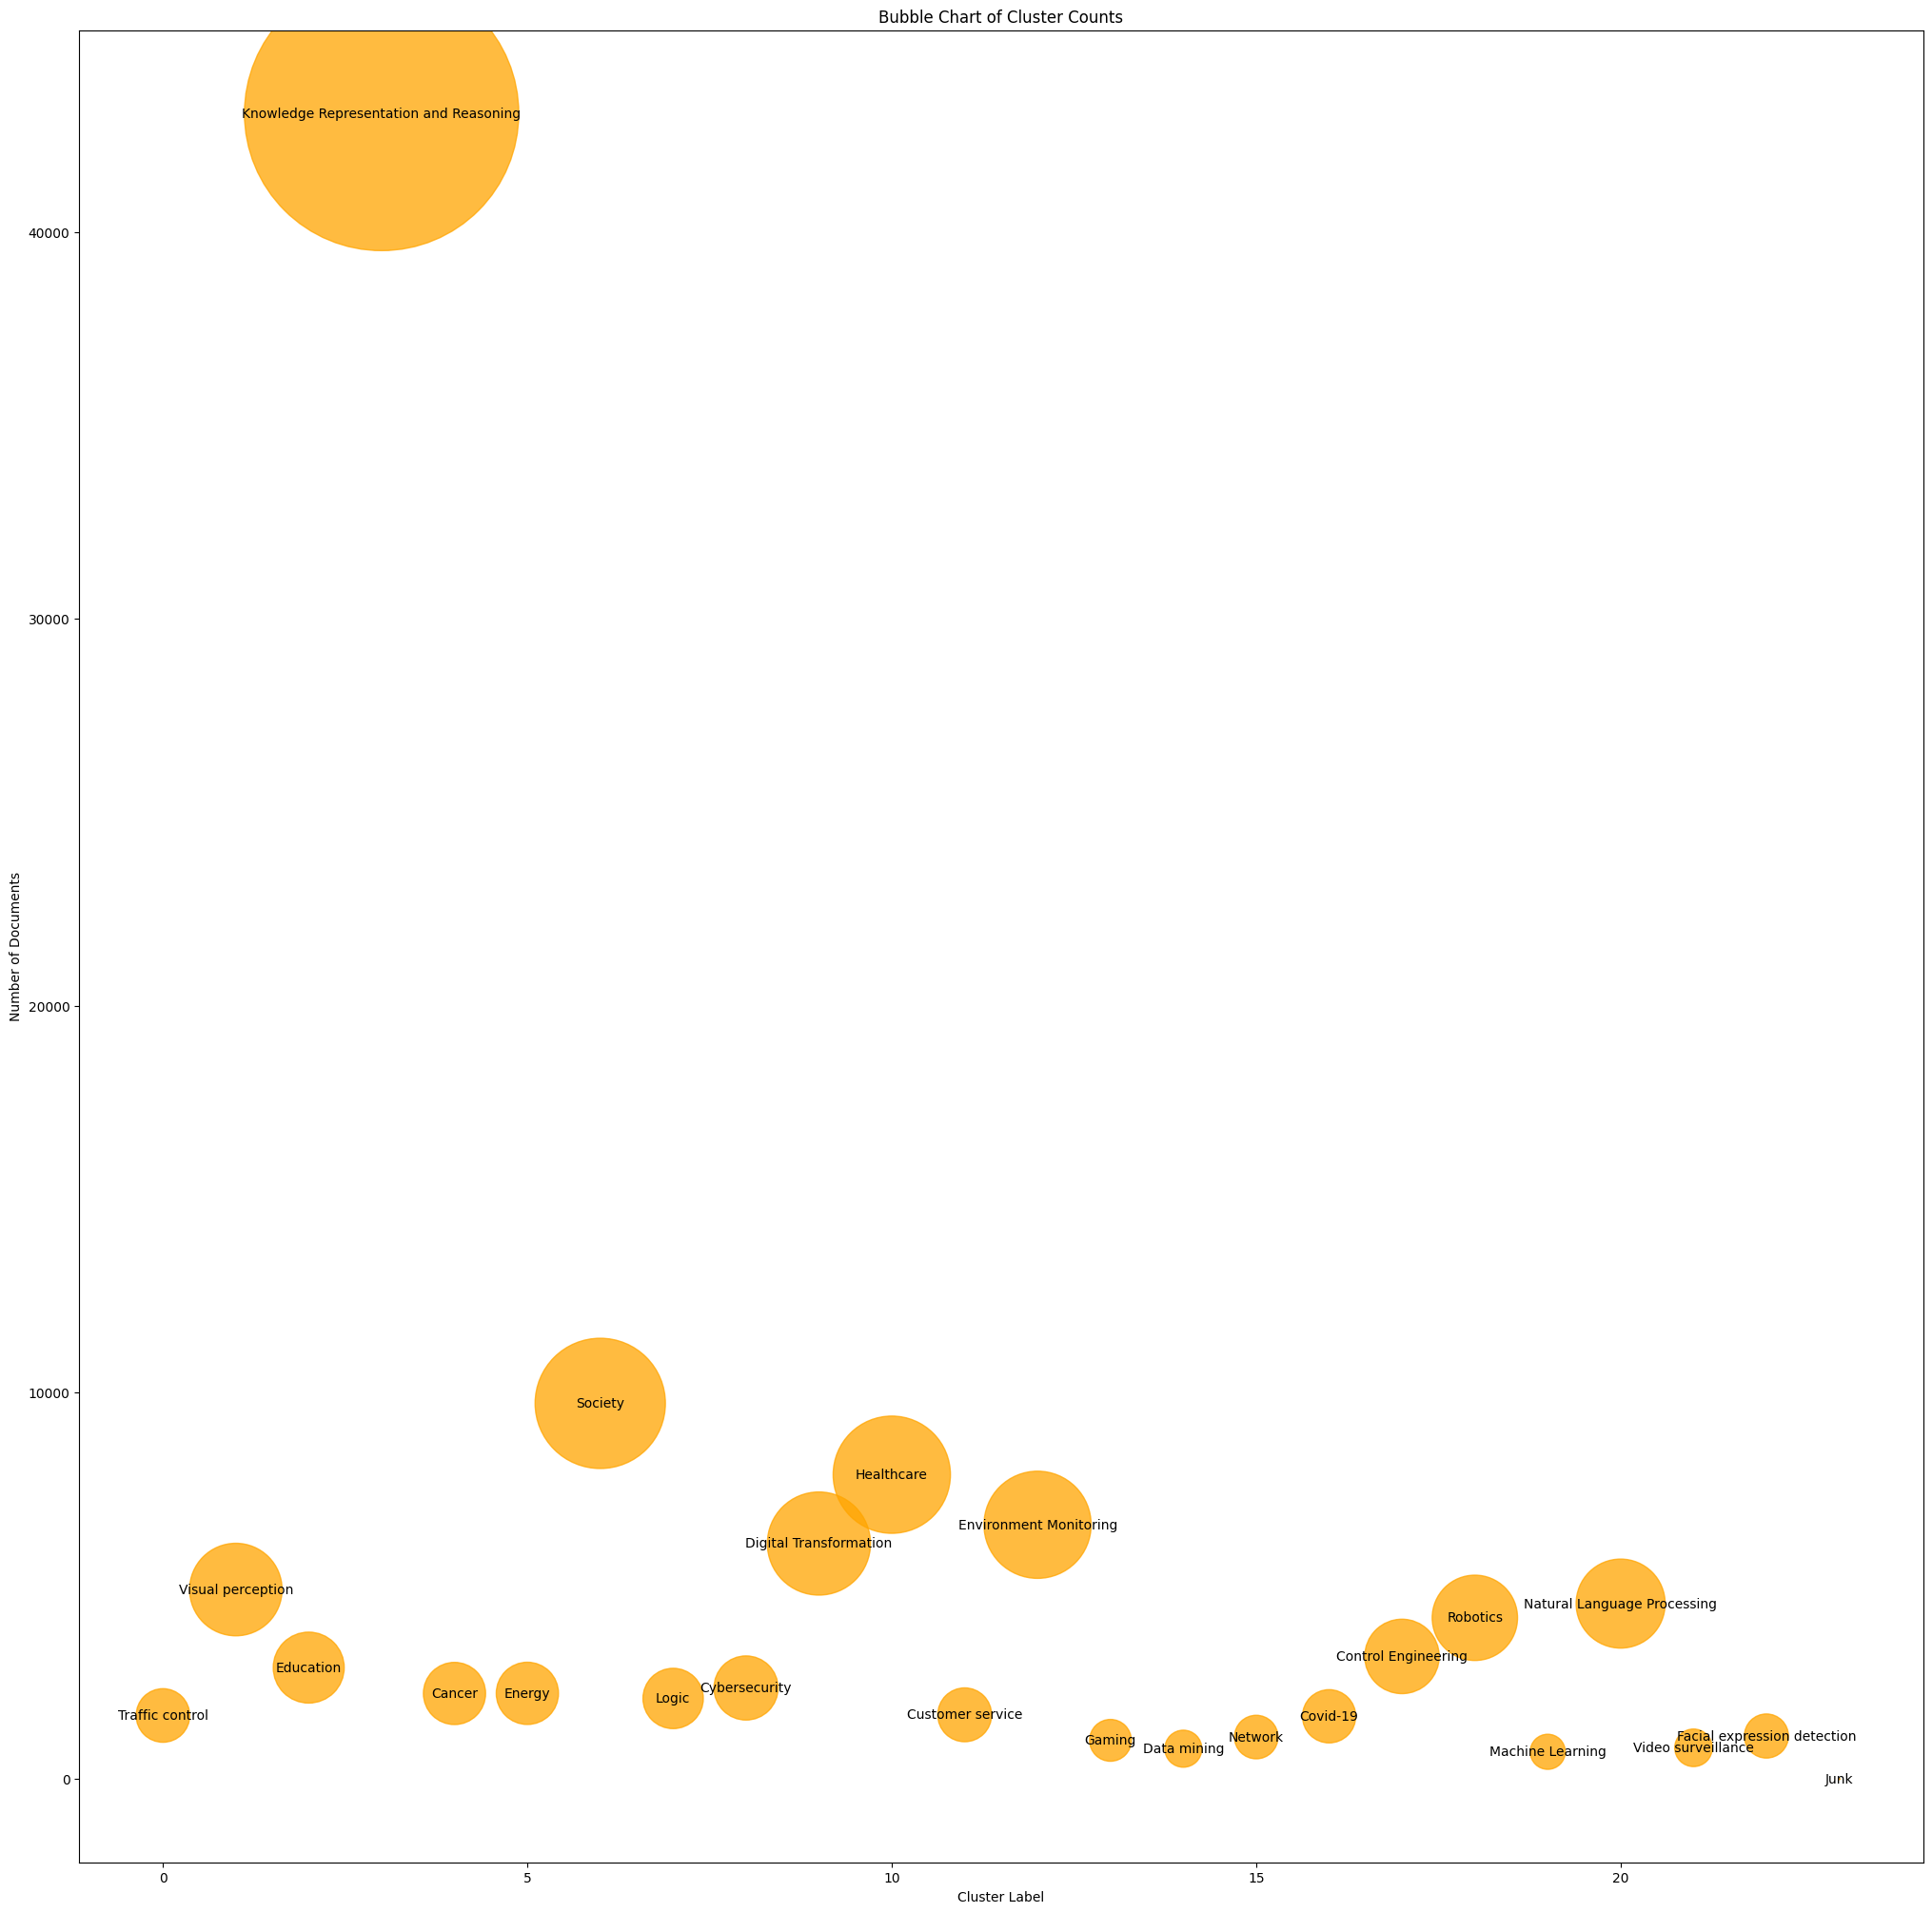

In [20]:
# Get the cluster labels and counts.
cluster_labels = list(range(0,k))
# Create a bubble chart of the cluster counts, with the size of the bubbles proportional to the number of documents in each cluster.
plt.figure(figsize=(25, 25))
plt.scatter(cluster_labels, cluster_counts, s=cluster_counts, c='orange', alpha=0.75)
labels = ["Traffic control","Visual perception", "Education", "Knowledge Representation and Reasoning", "Cancer", "Energy", "Society",
          "Logic", "Cybersecurity", "Digital Transformation", "Healthcare", "Customer service", "Environment Monitoring",
          "Gaming", "Data mining", "Network", "Covid-19", "Control Engineering", "Robotics", "Machine Learning", "Natural Language Processing",
          "Video surveillance", "Facial expression detection", "Junk"]

#Add a label to each cluster.
for i in range(len(cluster_labels)):
  plt.text(cluster_labels[i], cluster_counts[i], str(labels[i]), ha='center', va='center')
# Add a title and labels to the plot.
plt.title('Bubble Chart of Cluster Counts')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Documents')
plot2 = plt.gcf()
# Show the plot.
plt.show()
plot2.savefig("Bubble chart")

Mapping article DOI to the cluster labels


In [21]:
# Create dictionaries to store topic and DOI assignments
topic_assignments_dict = {}
doi_assignments_dict = {}

# Iterate over the topic assignments and DOIs
for i, (topic_assignment, doi_assign) in enumerate(zip(predicted_labels, df['doi'])):
    topic_assignments_dict[i] = topic_assignment

    if i not in doi_assignments_dict:
        doi_assignments_dict[i] = []
    doi_assignments_dict[i].append(doi_assign)

In [22]:
topic_to_doi_map = {}
for doi_index, topic_assignment in enumerate(predicted_labels):
  doi = doi_assignments_dict[doi_index]
  if topic_assignment not in topic_to_doi_map:
    topic_to_doi_map[topic_assignment] = []
  topic_to_doi_map[topic_assignment].append(doi)

Storing mapped articles to a csv file


In [23]:
# Specify the output CSV file path
output_file = '/content/gdrive/MyDrive/Colab Notebooks/Topic_DOI_MBK_Map.csv'

# Open the file in 'w' mode, create a CSV writer object
with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header
    writer.writerow(['Topic', 'DOI'])

    # Write the contents of the dictionary
    for key, value in topic_to_doi_map.items():
        writer.writerow([key, value])

print(f"Data written to '{output_file}' successfully.")

Data written to '/content/gdrive/MyDrive/Colab Notebooks/Topic_DOI_MBK_Map.csv' successfully.
